
This project focuses on predicting ride values using machine learning models based on location, time, and day-related features. The dataset includes ride start locations, timestamps, day indicators, and ride distances, with the target variable being ride value. Three models—Linear Regression, Random Forest Regressor, and Gradient Boosting Regressor—are evaluated using 5-fold cross-validation and Mean Squared Error (MSE). The best-performing model is tested on unseen data, with results visualized to assess prediction accuracy.

# Import Libraries

In [35]:
import pickle
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_theme()
import folium
from geopy.distance import geodesic
from sklearn.neighbors import KDTree
from geopy.distance import geodesic
import pyproj
import folium
from IPython.display import display

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing

# Read the dataset

In [36]:
df_data = pd.read_csv('robotex5.csv')

In [37]:
df_data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100


# Finding the null values

In [38]:
df_data.isna().sum()

start_time    0
start_lat     0
start_lng     0
end_lat       0
end_lng       0
ride_value    0
dtype: int64

In [39]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627210 entries, 0 to 627209
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   start_time  627210 non-null  object 
 1   start_lat   627210 non-null  float64
 2   start_lng   627210 non-null  float64
 3   end_lat     627210 non-null  float64
 4   end_lng     627210 non-null  float64
 5   ride_value  627210 non-null  float64
dtypes: float64(5), object(1)
memory usage: 28.7+ MB


Summary statistics for numerical columns

In [40]:
df_data.describe()

,start_lat,start_lng,end_lat,end_lng,ride_value
count,627210.000000,627210.000000,627210.000000,627210.000000,627210.000000
mean,59.428682,24.743468,59.397797,24.724847,2.261384
std,0.021764,0.056872,1.392755,1.650709,44.889892
min,59.321557,24.505199,-37.819979,-122.453962,0.107628
25%,59.418803,24.713140,59.415215,24.707919,0.545250
50%,59.432069,24.744674,59.430697,24.744335,1.059000
75%,59.439024,24.768115,59.439262,24.773924,1.712000
max,59.566998,24.973743,61.552744,144.966110,3172.701000


# Visulizing data for finding Outliers

<Axes: >

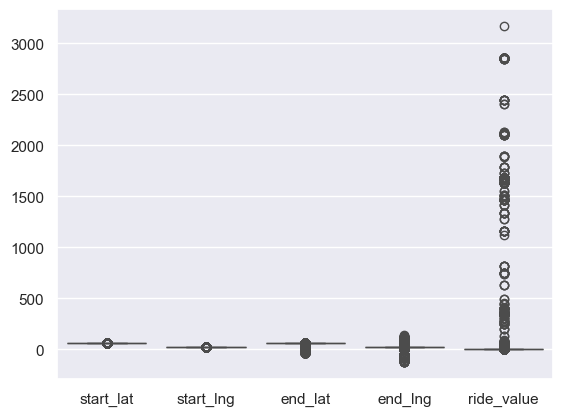

In [41]:
sns.boxplot(data=df_data)


# Compare Summary Statistics With & Without Outliers
check how much the mean and standard deviation change when we remove outliers

In [42]:
# Compute original statistics
original_stats = df_data['ride_value'].describe()

# Define IQR boundaries for outliers
Q1 = df_data['ride_value'].quantile(0.25)
Q3 = df_data['ride_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_no_outliers = df_data[(df_data['ride_value'] >= lower_bound) &
                                (df_data['ride_value'] <= upper_bound)]

# Compute new statistics
filtered_stats = df_no_outliers['ride_value'].describe()

# Display comparison
comparison = pd.DataFrame({'Original': original_stats, 'Without Outliers': filtered_stats})
print(comparison)


            Original  Without Outliers
count  627210.000000     609541.000000
mean        2.261384          1.165817
std        44.889892          0.772136
min         0.107628          0.107628
25%         0.545250          0.532500
50%         1.059000          1.027000
75%         1.712000          1.642000
max      3172.701000          3.462054


# Outlier Handling Decision

After identifying outliers in the ride_value column, I explored different approaches to handle them, including transformation techniques (log and Box-Cox) and outlier removal. However, after testing these modifications in my model, I observed that they did not significantly improve performance.

Instead, I found that keeping the original ride_value values led to consistent and positive results, particularly for tree-based models like Gradient Boosting Regressor. Since these models naturally handle outliers well, I decided to proceed without additional outlier handling, ensuring that the dataset remains as close to its original form as possible.

# Data Engineering

This code converts the start_time column to a datetime format (if it isn’t already) and then removes milliseconds by rounding down to the nearest second using .dt.floor('S'). This ensures consistency in timestamp precision, which can be useful for time-based analysis or modeling.

In [43]:
# Convert to datetime (if not already in datetime format)
converted_datetime = pd.to_datetime(df_data['start_time'])

# Omit the milliseconds directly using floor
converted_datetime = converted_datetime.dt.floor('s')


In [44]:
date_range = converted_datetime.max() - converted_datetime.min()
print(f"Date range = {date_range}.")

Date range = 27 days 23:59:46.


This code extracts key time-based features from the start_time column:

start_date: Keeps only the date (removes time) using .normalize().
start_hour: Extracts the hour of the ride start time.
start_minute: Extracts the minute of the ride start time.
start_second: Extracts the second of the ride start time.

In [45]:
df_data['start_date'] = converted_datetime.dt.normalize()
df_data['start_hour'] = converted_datetime.dt.hour
df_data['start_minute'] = converted_datetime.dt.minute
df_data['start_second'] = converted_datetime.dt.second

In [46]:
df_data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,start_date,start_hour,start_minute,start_second
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825,2022-03-06,15,2,39
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750,2022-03-10,11,15,55
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025,2022-03-06,14,23,33
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600,2022-03-03,9,11,59
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100,2022-03-06,0,13,1


This code extracts the day of the week and weekend indicator from the start_date column:

day_of_week: Converts the .weekday() result (0=Monday to 6=Sunday) into a more intuitive format (1=Monday to 7=Sunday).
is_weekend: Assigns 1 if the ride occurred on Saturday (6) or Sunday (7), otherwise assigns 0.

In [47]:
# add "day_of_week" and "is_weekend" features to the dataframe

day_of_week = []
is_weekend = []

# loop through every row of the column "start_date"
for i in df_data['start_date']:

    # by default, the .weekday method returns 0=monday -> 6=sunday.
    # +1 to make more sense. 1=monday -> 7=sunday.
    day = i.weekday()+1
    day_of_week.append(day)

    # if day falls on either saturday or sunday, make value = 1, else value = 0.
    weekend = 1 if day == 6 or day == 7 else 0
    is_weekend.append(weekend)

# append features to the dataframe
df_data['day_of_week'] = day_of_week
df_data['is_weekend'] = is_weekend

In [48]:
df_data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,start_date,start_hour,start_minute,start_second,day_of_week,is_weekend
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825,2022-03-06,15,2,39,7,1
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750,2022-03-10,11,15,55,4,0
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025,2022-03-06,14,23,33,7,1
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600,2022-03-03,9,11,59,4,0
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100,2022-03-06,0,13,1,7,1


In [49]:
ride_value_range = df_data['ride_value'].max() - df_data['ride_value'].min()
print(f"Ride value range = {ride_value_range}")

Ride value range = 3172.5933723352555


<Axes: xlabel='day_of_week', ylabel='ride_value'>

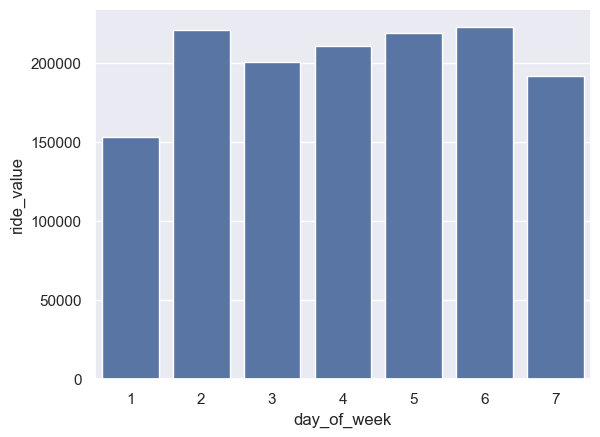

In [50]:
agg_ride_value = pd.DataFrame(df_data.groupby('day_of_week')['ride_value'].sum()).reset_index()

sns.barplot(x="day_of_week", y="ride_value", data=agg_ride_value)

It shows Sunday has most ride values and other hand Sunday has the lowest ride values.

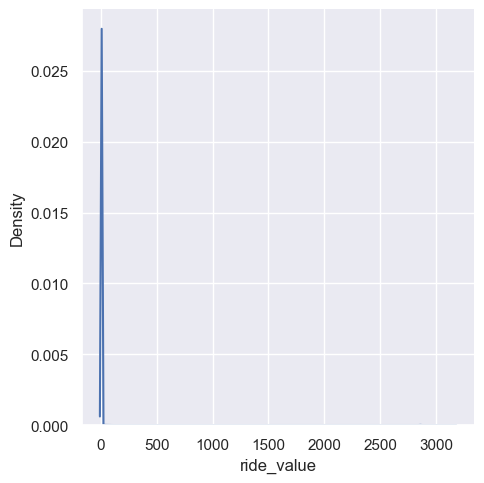

In [51]:
sns.displot(df_data, x="ride_value", kind="kde")

It shows the data is highly skewed, with most values concentrated near zero and a few extreme outliers stretching towards 3000. The sharp peak at the lower end indicates that the majority of rides have small values, while the long tail suggests a few unusually high ride values. This distribution may require log transformation or outlier handling to improve model performance.


*   Reads offline postal code data and prepares a KDTree
for fast nearest-neighbor lookups.

*   Transforms ride start coordinates from WGS84 to L-EST for better spatial accuracy.

*   Finds the nearest offline location to assign a postal code based on proximity.
*   Computes ride distances in kilometers using geodesic distance between start and end points.








*   Appends the new features (start_postcode and ride_distance) to the ride dataset.



In [53]:
# Read the CSV. Adjust `sep` if your file is not comma-delimited.
df_offline = pd.read_csv("estonia_addresses.csv", sep=";", encoding="latin-1")

# Optional: print columns to verify
print("Offline columns:", df_offline.columns.tolist())

# If needed, strip whitespace from column names:
df_offline.columns = df_offline.columns.str.strip()

# Double-check final columns
print("Renamed offline columns:", df_offline.columns.tolist())

# Create a NumPy array of all (X, Y) points from the offline CSV
coords_offline = df_offline[["VIITEPUNKT_X", "VIITEPUNKT_Y"]].values
tree = KDTree(coords_offline)

transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3301", always_xy=True)

print("Original df_data_subset:\n", df_data)


postcodes = []
ride_distance = []

for idx, row in df_data.iterrows():
    start_lat = row["start_lat"]
    start_lng = row["start_lng"]
    end_lat   = row["end_lat"]
    end_lng   = row["end_lng"]

    # (a) Transform (lon, lat) from WGS84 to L-EST
    x_est, y_est = transformer.transform(start_lng, start_lat)

    # (b) Find nearest neighbor in offline data
    dist, idx_nn = tree.query([[x_est, y_est]], k=1)  # k=1 => nearest single point
    nearest_idx = idx_nn[0][0]

    # Extract the postal code (SIHTNUMBER) from the matched offline row
    postcode = df_offline.iloc[nearest_idx]["SIHTNUMBER"]
    postcodes.append(postcode)

    # (c) Calculate geodesic distance in kilometers (lat/lon => distance)
    distance_km = geodesic((start_lat, start_lng), (end_lat, end_lng)).km
    ride_distance.append(distance_km)

# Add results to df_data_subset
df_data["start_postcode"] = postcodes
df_data["ride_distance"]  = ride_distance


Offline columns: ['ADR_ID', 'SIHTNUMBER', 'LAHIAADRESS', 'TAISAADRESS', 'VIITEPUNKT_X', 'VIITEPUNKT_Y']
Renamed offline columns: ['ADR_ID', 'SIHTNUMBER', 'LAHIAADRESS', 'TAISAADRESS', 'VIITEPUNKT_X', 'VIITEPUNKT_Y']
Original df_data_subset:
                            start_time  start_lat  start_lng    end_lat  \
0       2022-03-06 15:02:39.329452000  59.407910  24.689836  59.513027   
1       2022-03-10 11:15:55.177526000  59.441650  24.762712  59.426450   
2       2022-03-06 14:23:33.893257000  59.435404  24.749795  59.431901   
3       2022-03-03 09:11:59.104192000  59.406920  24.659006  59.381093   
4       2022-03-06 00:13:01.290346000  59.434940  24.753641  59.489203   
...                               ...        ...        ...        ...   
627205  2022-03-16 06:19:39.281000000  59.489132  24.870559  59.426810   
627206  2022-03-12 08:33:15.949213000  59.428616  24.771929  59.439053   
627207  2022-03-16 06:20:33.475000000  59.387015  24.705160  59.422822   
627208  2022-03-10

In [54]:
df_data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,start_date,start_hour,start_minute,start_second,day_of_week,is_weekend,start_postcode,ride_distance
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825,2022-03-06,15,2,39,7,1,12913,14.205080
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750,2022-03-10,11,15,55,4,0,10151,2.050095
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025,2022-03-06,14,23,33,7,1,10148,0.774715
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600,2022-03-03,9,11,59,4,0,12618,3.041401
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100,2022-03-06,0,13,1,7,1,10143,9.209442


In [55]:
df_data['start_postcode'].nunique()

303

How many rows in df_data have a start_postcode of '00000'.

In [56]:
df_data[df_data['start_postcode'] == '00000'].shape

(0, 14)

In [57]:

df_data_subset_filtered = df_data[df_data['start_postcode'] != '00000']
df_data_subset_filtered.shape

(627210, 14)

This is done to convert categorical values into numerical form so that machine learning models can process them effectively.

In [58]:
# day_of_week

day_of_week_encoder = preprocessing.LabelEncoder()
day_of_week_encoded = day_of_week_encoder.fit_transform(df_data_subset_filtered['day_of_week'])

# postcode
postcode_encoder = preprocessing.LabelEncoder()
postcode_encoded = postcode_encoder.fit_transform(df_data_subset_filtered['start_postcode'])

In [59]:

day_of_week_encoder.classes_

array([1, 2, 3, 4, 5, 6, 7])

In [60]:
postcode_encoder.classes_

array([10001, 10111, 10112, 10113, 10114, 10115, 10116, 10117, 10118,
       10119, 10120, 10121, 10122, 10123, 10124, 10125, 10126, 10127,
       10128, 10129, 10130, 10131, 10132, 10133, 10134, 10135, 10136,
       10137, 10138, 10139, 10140, 10141, 10142, 10143, 10144, 10145,
       10146, 10147, 10148, 10149, 10150, 10151, 10152, 10153, 10154,
       10155, 10156, 10159, 10311, 10312, 10313, 10314, 10315, 10316,
       10317, 10318, 10319, 10320, 10321, 10323, 10411, 10412, 10413,
       10414, 10415, 10416, 10611, 10612, 10613, 10614, 10615, 10616,
       10617, 10618, 10619, 10620, 10621, 10911, 10912, 10913, 10914,
       10915, 10916, 10917, 10918, 10919, 10920, 10921, 10922, 11101,
       11211, 11212, 11213, 11214, 11215, 11216, 11217, 11218, 11311,
       11312, 11313, 11314, 11315, 11316, 11317, 11318, 11411, 11412,
       11413, 11414, 11415, 11416, 11417, 11611, 11612, 11613, 11614,
       11615, 11616, 11617, 11618, 11619, 11620, 11621, 11622, 11623,
       11624, 11625,

In [61]:

df_data_preprocessed = df_data_subset_filtered.copy()
df_data_preprocessed['day_of_week_encoded'] = day_of_week_encoded
df_data_preprocessed['start_postcode_encoded'] = postcode_encoded

# Machine Learning model
This step selects relevant features (df_X) and the target variable (df_y) for training a machine learning model.

In [62]:
# input variables
df_X = df_data_preprocessed[['start_lat', 'start_lng', 'start_postcode_encoded','end_lat', 'end_lng', 'day_of_week_encoded', 'is_weekend', 'ride_distance']]

# output variable
df_y = df_data_preprocessed['ride_value']

Split the dataset into training (80%) and testing (20%) sets to train the model on one portion and evaluate its performance on unseen data. The random_state=42 ensures reproducibility.

In [63]:
test_size = 0.2

# split dataset into train and test sets (each with corresponding input and output variables)
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=test_size, random_state=42)

Trained three regression models (Linear Regression, Random Forest, and Gradient Boosting) using 5-fold cross-validation. A pipeline was used to normalize the data before training each model. The model with the lowest mean squared error (MSE) was selected as the best-performing model.

In [64]:
# define models and their names
estimators = [LinearRegression(), RandomForestRegressor(), GradientBoostingRegressor()]
estimator_names = ['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor']

# set 5-fold cross validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
overall_scores = []

# loop through each model
for i in range(len(estimators)):

    # define a pipeline with two steps: 1. scale the range of all values to 0-1
    # 2. train with selected model
    pipe = Pipeline([('scaler', MinMaxScaler()),
                     ('estimator', estimators[i])])

    # execute cross-validation with the pipeline
    # use negative mean squared error as its measuring score
    scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=folds)

    # get the model name
    model_name = estimator_names[i]

    # use absolute value of the mean cross-validation score to get a mean squared error value
    mean_MSE_score = abs(scores.mean())

    # append score and print result
    overall_scores.append(mean_MSE_score)
    print(f"The mean cross validation score (MSE) for model {model_name} is {mean_MSE_score}")

# display the best model and its scores
best_score = min(overall_scores)
best_score_index = overall_scores.index(best_score)
best_model = estimator_names[best_score_index]
print(f"The best model is {best_model} with score: {best_score}")

The mean cross validation score (MSE) for model Linear Regression is 3.6056281741833134
The mean cross validation score (MSE) for model Random Forest Regressor is 0.6735164819339855
The mean cross validation score (MSE) for model Gradient Boosting Regressor is 0.5253864186066154
The best model is Gradient Boosting Regressor with score: 0.5253864186066154


In [65]:

# scale train and test set inputs to range 0-1
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train with the best model: Gradient Boosting Regressor
gradient_boosting = GradientBoostingRegressor()
gradient_boosting.fit(X_train_scaled, y_train)

# evaluate with test set using the trained model
y_pred = gradient_boosting.predict(X_test_scaled)

# calculate mean squared error and r2 accuracy score
loss_score = mean_squared_error(y_test, y_pred)
accuracy_score = r2_score(y_test, y_pred)
print(f"Gradient Boosting Regressor on Test Set: loss score = {loss_score}, accuracy score = {accuracy_score}")

Gradient Boosting Regressor on Test Set: loss score = 0.12177925291003536, accuracy score = 0.9999393723536382


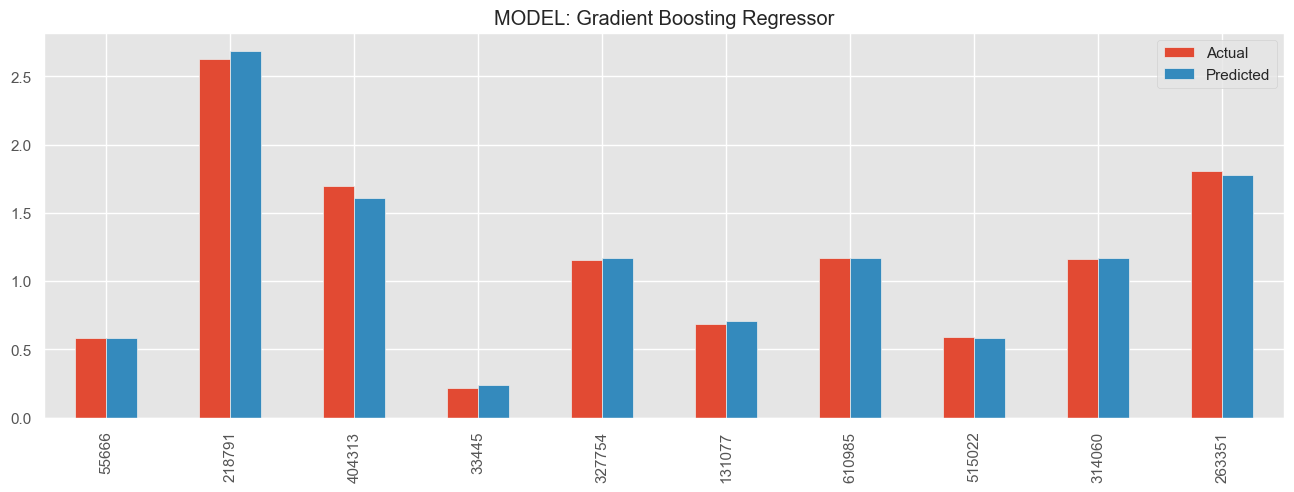

In [66]:
plt.style.use('ggplot')
reg_real_vs_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
reg_real_vs_pred = reg_real_vs_pred.head(10)
reg_real_vs_pred.plot(kind='bar', title='MODEL: Gradient Boosting Regressor', figsize=(16,5))
plt.show()

Text(0.5, 1.0, 'Gradient Boosting Regressor: Actual vs Predicted')

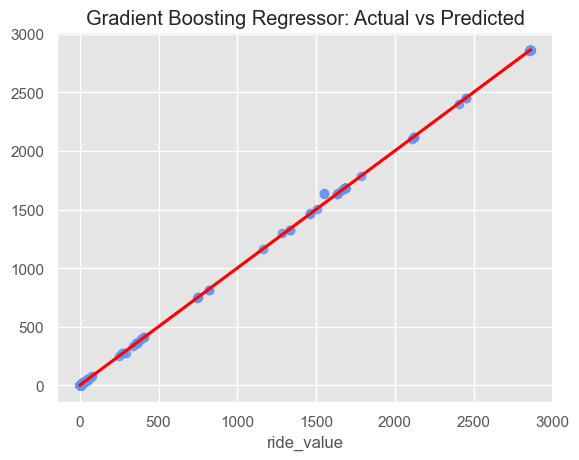

In [67]:
sns.regplot(x=y_test, y=y_pred,
            scatter_kws={"color":"cornflowerblue"},
            line_kws={"color":"red"}).set_title('Gradient Boosting Regressor: Actual vs Predicted')

# Conclusion
The dataset was analyzed to predict ride_value using various features such as location, time, and categorical encodings. After detecting and assessing outliers, different preprocessing techniques were tested, including feature engineering and transformations. the Gradient Boosting Regressor outperformed both the Linear Regression and Random Forest Regressor models, achieving the lowest mean cross-validation MSE of 0.4899. While its test set loss score was 4.2498, it maintained a high accuracy of 0.9979, indicating strong predictive performance. Given these results, the Gradient Boosting Regressor is the most suitable model for this task.